In [1]:
import os
import time
import numpy as np # 
import pandas as pd 
from tqdm import tqdm, tqdm_pandas, tqdm_notebook
from sklearn.metrics import f1_score, roc_auc_score
import gc
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import *
import keras
import pickle
from sklearn.utils import compute_class_weight

Using TensorFlow backend.


In [2]:
import sys
print(K.tensorflow_backend._get_available_gpus())

['/job:localhost/replica:0/task:0/device:GPU:0']


In [3]:
path = "../input/qnb_finansbank_yarisma/QNB_Finansbank_Yapay_Öğrenme_Yarışması/"

In [4]:
train_cust = pd.read_csv(path+"Koc_Yaz_Okulu_Data_Train_Cust.txt", sep=";")
train_ag = pd.read_csv(path+"Koc_Yaz_Okulu_Data_Train_Agent.txt", sep=";")
y_train = pd.read_csv(path+"Koc_Yaz_Okulu_Data_Train_Target.txt", sep=";")

In [5]:
test_cust = pd.read_csv(path+"Koc_Yaz_Okulu_Data_Test_Cust.txt", sep=";")
test_ag = pd.read_csv(path+"Koc_Yaz_Okulu_Data_Test_Agent.txt", sep=";")


In [6]:
test_cust.shape, test_ag.shape

((12721, 2), (12721, 2))

In [7]:
train_ag.head()

,ID,AGENT_TXT
0,29140726,X7092177 X7352233 X8382776 X5850527 X9875515 X...
1,29472320,X3544666 X1643318 X5329880 X4336932 X9875515 X...
2,29012836,X7092177 X5266558 X1638055 X3274335 X2029222 X...
3,29161698,X5168898 X2958188 X5850527 X3798496 X8950102 X...
4,28599552,X7358694 X1638055 X6932443 X6672085 X3262622 X...


In [8]:
y_train.head()

,ID,LABEL_1,LABEL_2,LABEL_3,LABEL_4,LABEL_5,LABEL_6,LABEL_7,LABEL_8,LABEL_9,LABEL_10,LABEL_11,LABEL_12,LABEL_13,LABEL_14,LABEL_15,LABEL_16,LABEL_17,LABEL_18,LABEL_19,LABEL_20,LABEL_21,LABEL_22,LABEL_23,LABEL_24,LABEL_25,LABEL_26,LABEL_27,LABEL_28,LABEL_29,LABEL_30,LABEL_31,LABEL_32,LABEL_33,LABEL_34,LABEL_35,LABEL_36,LABEL_37,LABEL_38,LABEL_39,LABEL_40,LABEL_41,LABEL_42,LABEL_43,LABEL_44,LABEL_45,LABEL_46,LABEL_47,LABEL_48,LABEL_49,LABEL_50,LABEL_51,LABEL_52,LABEL_53,LABEL_54,LABEL_55,LABEL_56
0,28902722,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,30265364,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,28732508,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,29109715,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,30198070,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
train_df = train_cust.merge(train_ag, on="ID", how="left")

In [10]:
test_df = test_cust.merge(test_ag, on="ID", how="left")

In [11]:
train_df.shape, test_df.shape

((40000, 3), (12721, 3))

In [12]:
train_df.head()

,ID,CUST_TXT,AGENT_TXT
0,29140726,X7092177 X7352233 X6482199 X3262622 X7596215 X...,X7092177 X7352233 X8382776 X5850527 X9875515 X...
1,29472320,X1317264 X3511202 X3074897 X8657971 X9504814 X...,X3544666 X1643318 X5329880 X4336932 X9875515 X...
2,29012836,X7092177 X3751173 X2408482 X9784649 X3074897 X...,X7092177 X5266558 X1638055 X3274335 X2029222 X...
3,29161698,X7092177 X5266558 X9587719 X7330829 X9093733 X...,X5168898 X2958188 X5850527 X3798496 X8950102 X...
4,28599552,X1236709 X3262622 X3422547 X1495491 X4692604 X...,X7358694 X1638055 X6932443 X6672085 X3262622 X...


In [13]:
train_df.merge(y_train, on="ID", how="left").head()

,ID,CUST_TXT,AGENT_TXT,LABEL_1,LABEL_2,LABEL_3,LABEL_4,LABEL_5,LABEL_6,LABEL_7,LABEL_8,LABEL_9,LABEL_10,LABEL_11,LABEL_12,LABEL_13,LABEL_14,LABEL_15,LABEL_16,LABEL_17,LABEL_18,LABEL_19,LABEL_20,LABEL_21,LABEL_22,LABEL_23,LABEL_24,LABEL_25,LABEL_26,LABEL_27,LABEL_28,LABEL_29,LABEL_30,LABEL_31,LABEL_32,LABEL_33,LABEL_34,LABEL_35,LABEL_36,LABEL_37,LABEL_38,LABEL_39,LABEL_40,LABEL_41,LABEL_42,LABEL_43,LABEL_44,LABEL_45,LABEL_46,LABEL_47,LABEL_48,LABEL_49,LABEL_50,LABEL_51,LABEL_52,LABEL_53,LABEL_54,LABEL_55,LABEL_56
0,29140726,X7092177 X7352233 X6482199 X3262622 X7596215 X...,X7092177 X7352233 X8382776 X5850527 X9875515 X...,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,29472320,X1317264 X3511202 X3074897 X8657971 X9504814 X...,X3544666 X1643318 X5329880 X4336932 X9875515 X...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,29012836,X7092177 X3751173 X2408482 X9784649 X3074897 X...,X7092177 X5266558 X1638055 X3274335 X2029222 X...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,29161698,X7092177 X5266558 X9587719 X7330829 X9093733 X...,X5168898 X2958188 X5850527 X3798496 X8950102 X...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,28599552,X1236709 X3262622 X3422547 X1495491 X4692604 X...,X7358694 X1638055 X6932443 X6672085 X3262622 X...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
stats_df = pd.DataFrame(index=train_df.index)

In [15]:
stats_df['total_length'] = train_df['CUST_TXT'].apply(len)
stats_df['num_words'] = train_df['CUST_TXT'].apply(lambda comment: len(comment.split()))
stats_df['num_unique_words'] = train_df['CUST_TXT'].apply(lambda comment: len(set(w for w in comment.split())))

In [16]:
stats_df.head()

,total_length,num_words,num_unique_words
0,332,37,29
1,1043,116,46
2,1025,114,66
3,1781,198,93
4,692,77,40


In [17]:
stats_df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_length,40000.0,752.2937,402.057276,98.0,440.0,683.0,989.0,3059.0
num_words,40000.0,83.6993,44.673031,11.0,49.0,76.0,110.0,340.0
num_unique_words,40000.0,49.9131,19.468796,4.0,35.0,48.0,63.0,138.0


In [18]:
test_id = test_df["ID"]

### Model

In [19]:
max_features = 2000
max_len = 50
embed_size = 40

In [20]:
tokenizer = Tokenizer(num_words=max_features)

In [21]:
train_agent = train_df["AGENT_TXT"].fillna("_##_").values
test_agent = test_df["AGENT_TXT"].fillna("_##_").values

In [22]:
train_cust = train_df["CUST_TXT"].fillna("_##_").values
test_cust = test_df["CUST_TXT"].fillna("_##_").values

In [23]:
tokenizer.fit_on_texts(list(train_agent) + list(test_agent))
train_agent = tokenizer.texts_to_sequences(train_agent)
test_agent = tokenizer.texts_to_sequences(test_agent)

In [24]:
tokenizer.fit_on_texts(list(train_cust) + list(test_cust))
train_cust = tokenizer.texts_to_sequences(train_cust)
test_cust = tokenizer.texts_to_sequences(test_cust)

In [25]:
train_agent = pad_sequences(train_agent, maxlen=max_len)
test_agent = pad_sequences(test_agent, maxlen=max_len)

In [26]:
train_cust = pad_sequences(train_cust, maxlen=max_len)
test_cust = pad_sequences(test_cust, maxlen=max_len)

In [27]:
df_train = np.hstack([train_agent, train_cust])
df_test = np.hstack([test_agent, test_cust])

In [28]:
df_train.shape, df_test.shape

((40000, 100), (12721, 100))

In [29]:
df_train[:1]

array([[   0,    0,    0,    0,    0,   21,  154,  214,    7,   11,   32,
           3,   26,   38,   30,   69,   39,  146,   12,   55,  132,   78,
         700,    7,   11,   55,  132,   78,  146,    1,   70,   87,  177,
         101,  597,    1,    9,   87,   57,   55,  132,   26,   32,    3,
          78,   59,    3,   21,   15,   53,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,   16,  110,  958,
          66,   19,    4,  206,    4,  206,  129,   24,    5,  383,    8,
          55,  114,    5,    8,  247,  270,   53,  196,  339, 1108,  145,
         196,  179,    1,   38,   11,  196,   24,   69,  138,   86,  207,
          11]], dtype=int32)

In [30]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_normal')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [31]:
labels = y_train.columns.tolist()[1:]

In [32]:
bs = 256

In [33]:
gc.collect()

0

In [34]:
!nvidia-smi

Tue Jun 18 08:06:49 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    32W / 250W |    337MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [35]:
def get_model_all(max_len=df_train.shape[1]):
    inp = Input(shape=(max_len,))
    x = Embedding(max_features, embed_size, trainable=False)(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True ))(x)
    y = Bidirectional(CuDNNGRU(32, return_sequences=True))(x)
    #x = Bidirectional(CuDNNGRU(96,return_sequences=True))(x)
    #x = Bidirectional(CuDNNGRU(64,return_sequences=True))(x) 
    
    
    atten_1 = Attention(max_len)(x)
    atten_2 = Attention(max_len)(y)
    avg_pool = GlobalAveragePooling1D()(y)
    max_pool = GlobalMaxPooling1D()(y)
    
    conc = concatenate([atten_1, atten_2, avg_pool, max_pool])
    conc = BatchNormalization()(conc)
    conc = Dropout(0.1)(conc) 
    outp = Dense(1, activation="sigmoid")(conc)
    adam = optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    #model.summary()
    return model

In [36]:
model_all = get_model_all()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [37]:
model_all.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 40)      80000       input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 100, 40)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 128)     54272       spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
bidirectio

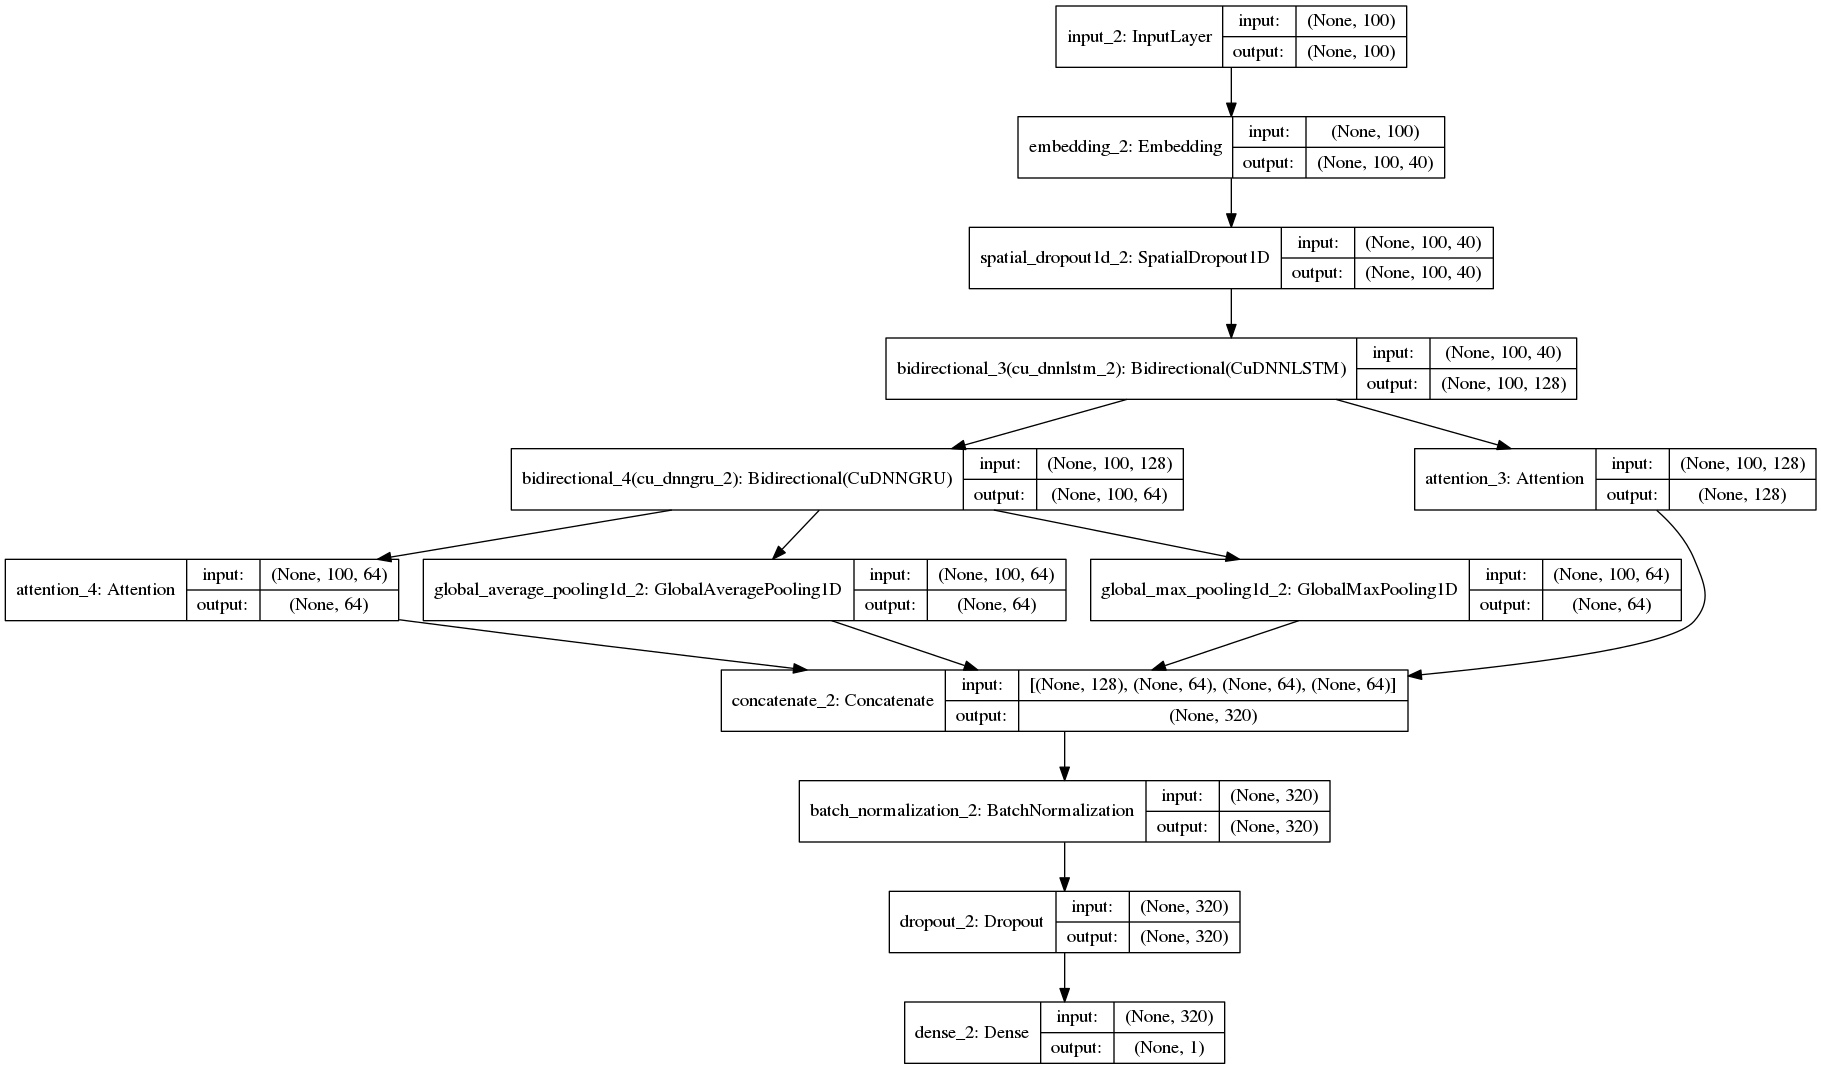

In [38]:
from keras.utils import plot_model
plot_model(get_model_all(), to_file='model.png',show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

In [39]:
submission_all = pd.DataFrame(index=test_df["ID"], columns=labels)

In [40]:
%%time
for label in labels:
    print("Label:", label)
    model_all = get_model_all()
    cw = compute_class_weight("balanced", np.unique(y_train[label]), y_train[label])
    model_all.fit(df_train, y_train[label], batch_size=bs, epochs=10, verbose=2, validation_split = 0.1, class_weight={0:1, 1:cw[1]})
    submission_all[label] = model_all.predict(df_test)

Label: LABEL_1
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 36000 samples, validate on 4000 samples
Epoch 1/10
 - 10s - loss: 0.9240 - acc: 0.9065 - val_loss: 2.2542 - val_acc: 0.9123
Epoch 2/10
 - 4s - loss: 0.9174 - acc: 0.9142 - val_loss: 0.9530 - val_acc: 0.9123
Epoch 3/10
 - 4s - loss: 0.9163 - acc: 0.9142 - val_loss: 0.9327 - val_acc: 0.9123
Epoch 4/10
 - 4s - loss: 0.9153 - acc: 0.9142 - val_loss: 1.0693 - val_acc: 0.0910
Epoch 5/10
 - 4s - loss: 0.9136 - acc: 0.9141 - val_loss: 1.1679 - val_acc: 0.0877
Epoch 6/10
 - 4s - loss: 0.9127 - acc: 0.9141 - val_loss: 0.9981 - val_acc: 0.9123
Epoch 7/10
 - 4s - loss: 0.9124 - acc: 0.9140 - val_loss: 0.9396 - val_acc: 0.9123
Epoch 8/10
 - 4s - loss: 0.9107 - acc: 0.9137 - val_loss: 0.9549 - val_acc: 0.9123
Epoch 9/10
 - 4s - loss: 0.9088 - acc: 0.9138 - val_loss: 0.9558 - val_acc: 0.9123
Epoch 10/10
 - 4s - loss: 0.9077 - acc: 0.9127 - val_loss: 0.9

In [41]:
submission_all.head()

,LABEL_1,LABEL_2,LABEL_3,LABEL_4,LABEL_5,LABEL_6,LABEL_7,LABEL_8,LABEL_9,LABEL_10,LABEL_11,LABEL_12,LABEL_13,LABEL_14,LABEL_15,LABEL_16,LABEL_17,LABEL_18,LABEL_19,LABEL_20,LABEL_21,LABEL_22,LABEL_23,LABEL_24,LABEL_25,LABEL_26,LABEL_27,LABEL_28,LABEL_29,LABEL_30,LABEL_31,LABEL_32,LABEL_33,LABEL_34,LABEL_35,LABEL_36,LABEL_37,LABEL_38,LABEL_39,LABEL_40,LABEL_41,LABEL_42,LABEL_43,LABEL_44,LABEL_45,LABEL_46,LABEL_47,LABEL_48,LABEL_49,LABEL_50,LABEL_51,LABEL_52,LABEL_53,LABEL_54,LABEL_55,LABEL_56
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
29408483,0.375211,0.297849,0.265300,0.350288,0.154023,0.345622,0.276210,0.422184,0.424674,0.400552,0.216312,0.239041,0.519539,0.197201,0.536737,0.308854,0.317217,0.203004,0.447135,0.318407,0.307669,0.440042,0.526765,0.456734,0.253003,0.116505,0.345685,0.256384,0.454443,0.136368,0.037330,0.356299,0.145584,0.158070,0.063105,0.474795,0.349344,0.371402,0.462295,0.074447,0.400013,0.144995,0.599085,0.177583,0.271306,0.078640,0.130656,0.608880,0.023444,0.216007,0.044471,0.790826,0.615428,0.060955,8.940697e-07,0.277034
29164528,0.390474,0.273048,0.327629,0.346334,0.136660,0.293070,0.257421,0.476090,0.384906,0.450669,0.263949,0.248000,0.512216,0.254772,0.478946,0.176017,0.307289,0.191435,0.265389,0.318141,0.147023,0.366116,0.641957,0.507710,0.315365,0.081191,0.309972,0.317458,0.473557,0.113448,0.053010,0.315977,0.204194,0.133927,0.089654,0.544612,0.350240,0.394794,0.295509,0.072132,0.632276,0.258283,0.660273,0.089375,0.205327,0.049376,0.247008,0.221580,0.035707,0.557513,0.008231,0.555697,0.483235,0.018296,1.311302e-06,0.356881
29475634,0.387763,0.325422,0.228740,0.323630,0.119543,0.377189,0.202776,0.417498,0.418968,0.479711,0.275895,0.137610,0.444862,0.244024,0.369476,0.221020,0.293768,0.170527,0.401522,0.341259,0.309981,0.366640,0.582397,0.504908,0.227994,0.090912,0.196414,0.329291,0.271887,0.118141,0.064196,0.277095,0.158241,0.199215,0.064070,0.467808,0.569490,0.485413,0.377568,0.035061,0.723149,0.087596,0.550299,0.126805,0.282151,0.073773,0.170839,0.117012,0.051851,0.261392,0.603740,0.489925,0.231491,0.019536,3.457069e-06,0.108441
30133404,0.364922,0.276260,0.306559,0.437671,0.116419,0.422102,0.241749,0.471419,0.368978,0.385439,0.262283,0.109220,0.526896,0.236059,0.367466,0.166012,0.317508,0.211784,0.337888,0.468679,0.179275,0.366717,0.549959,0.423666,0.328701,0.125016,0.296373,0.324396,0.366027,0.153357,0.063499,0.412587,0.160946,0.245864,0.072131,0.660811,0.542503,0.437505,0.576502,0.132781,0.613927,0.161925,0.454536,0.120556,0.202739,0.078532,0.453060,0.548047,0.058342,0.471202,0.050729,0.809312,0.349704,0.079419,5.543232e-06,0.501348
29333466,0.479236,0.271470,0.291775,0.390880,0.163174,0.349389,0.196093,0.463591,0.384706,0.446520,0.166840,0.240279,0.433335,0.220110,0.427684,0.176694,0.356380,0.164768,0.269165,0.434936,0.201477,0.407721,0.405988,0.481090,0.230533,0.118604,0.344441,0.297559,0.500397,0.116533,0.043100,0.290736,0.113262,0.239416,0.064534,0.505296,0.617156,0.442336,0.346974,0.069070,0.565067,0.250068,0.539528,0.098351,0.159062,0.323081,0.425882,0.208105,0.026306,0.221252,0.082105,0.748609,0.338905,0.064247,8.642673e-07,0.314960


In [42]:
submission_all.describe().T

,count,mean,std,min,25%,50%,75%,max
LABEL_1,12721.0,0.406400,0.045888,0.250177,0.374624,0.405924,0.437251,0.581610
LABEL_2,12721.0,0.288898,0.022291,0.205882,0.273759,0.288714,0.303382,0.392557
LABEL_3,12721.0,0.279154,0.039231,0.144858,0.251981,0.276712,0.304075,0.460647
LABEL_4,12721.0,0.376491,0.046145,0.187167,0.345100,0.375631,0.407011,0.566920
LABEL_5,12721.0,0.135843,0.026826,0.048987,0.117050,0.133374,0.152032,0.291958
LABEL_6,12721.0,0.353397,0.040204,0.220310,0.325513,0.351337,0.380322,0.511328
LABEL_7,12721.0,0.253751,0.032973,0.137056,0.230861,0.252720,0.275267,0.391313
LABEL_8,12721.0,0.471640,0.052788,0.285626,0.435651,0.470578,0.507057,0.653889
LABEL_9,12721.0,0.387476,0.043070,0.241546,0.358402,0.388073,0.416723,0.548154
LABEL_10,12721.0,0.429143,0.039341,0.289500,0.401946,0.428572,0.455896,0.587543


In [43]:
for label in labels:
    print(np.round(submission_all[label]).value_counts())

0.0    12436
1.0      285
Name: LABEL_1, dtype: int64
0.0    12721
Name: LABEL_2, dtype: int64
0.0    12721
Name: LABEL_3, dtype: int64
0.0    12652
1.0       69
Name: LABEL_4, dtype: int64
0.0    12721
Name: LABEL_5, dtype: int64
0.0    12714
1.0        7
Name: LABEL_6, dtype: int64
0.0    12721
Name: LABEL_7, dtype: int64
0.0    8968
1.0    3753
Name: LABEL_8, dtype: int64
0.0    12663
1.0       58
Name: LABEL_9, dtype: int64
0.0    12238
1.0      483
Name: LABEL_10, dtype: int64
0.0    12720
1.0        1
Name: LABEL_11, dtype: int64
0.0    12721
Name: LABEL_12, dtype: int64
0.0    9556
1.0    3165
Name: LABEL_13, dtype: int64
0.0    12721
Name: LABEL_14, dtype: int64
0.0    10102
1.0     2619
Name: LABEL_15, dtype: int64
0.0    12721
Name: LABEL_16, dtype: int64
0.0    12721
Name: LABEL_17, dtype: int64
0.0    12721
Name: LABEL_18, dtype: int64
0.0    12547
1.0      174
Name: LABEL_19, dtype: int64
0.0    12635
1.0       86
Name: LABEL_20, dtype: int64
0.0    12721
Name: LABEL_21, d

In [44]:
submission_all.to_csv("submission_all.csv")
submission_all.to_csv("submission_all.txt", sep=";")

In [45]:
K.clear_session()
gc.collect()

230

In [46]:
!nvidia-smi

Tue Jun 18 09:18:03 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    38W / 250W |  15663MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  